In [17]:
import squigglepy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

from chip_estimates_utils import (
    estimate_chip_sales,
    summarize_calendar_quarters,
    interpolate_to_calendar_quarters,
    verify_calendar_quarter_interpolation
)

# ==================
# Helper functions
# ==================

def normalize_shares(raw_shares):
    """Normalize share values to sum to 1."""
    total = sum(raw_shares.values())
    return {k: v / total for k, v in raw_shares.items()}


def compute_h100_equivalents(chip_counts, chip_specs, h100_tops=1979):
    """Convert chip counts to H100 equivalents based on 8-bit TOPS."""
    return {
        version: counts * (chip_specs[version]['tops'] / h100_tops)
        for version, counts in chip_counts.items()
    }


def print_cumulative_summary(cumulative, chip_specs, title="Cumulative Production"):
    """Print formatted summary of cumulative chip counts with percentiles."""
    print(f"\n{title}")
    print(f"{'Version':<12} {'p5':>12} {'p50':>12} {'p95':>12}")
    print("-" * 51)

    grand_total = None
    for version in chip_specs:
        arr = cumulative[version]
        if arr.sum() > 0:
            if grand_total is None:
                grand_total = np.zeros_like(arr)
            grand_total += arr
            print(f"{version:<12} {int(np.percentile(arr, 5)):>12,} {int(np.percentile(arr, 50)):>12,} {int(np.percentile(arr, 95)):>12,}")

    if grand_total is not None:
        print("-" * 51)
        print(f"{'TOTAL':<12} {int(np.percentile(grand_total, 5)):>12,} {int(np.percentile(grand_total, 50)):>12,} {int(np.percentile(grand_total, 95)):>12,}")

In [ ]:
import requests
import zipfile
import io

# Download the zip file
url = "https://epoch.ai/data/ai_chip_sales.zip"
response = requests.get(url)

# Extract and read chip_types.csv
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("chip_types.csv") as f:
        chip_types_df = pd.read_csv(f)

print(chip_types_df.head())

In [18]:
# NVIDIA chip specs: 8-bit TFLOP/s
CHIP_SPECS = {
    'A100':      {'tops': 624},
    'A800':      {'tops': 624},
    'H100/H200': {'tops': 1979},
    'H800':      {'tops': 1979},
    'H20':       {'tops': 296},
    'B200':      {'tops': 5000},
    'B300':      {'tops': 5000},
}
CHIP_TYPES = list(CHIP_SPECS.keys())

# Colors for visualization
CHIP_COLORS = {
    'A100': 'lightcoral',
    'A800': 'sienna',
    'H100/H200': 'steelblue',
    'H800': 'firebrick',
    'H20': 'orange',
    'B200': 'mediumseagreen',
    'B300': 'seagreen',
}

# Hardware share of compute revenue (vs cloud/software)
HARDWARE_SHARE = sq.to(0.96, 0.99, credibility=80)

In [19]:
# Load revenue and price data from Google Sheets
revenue_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0"
).set_index('Quarter')

prices_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
).set_index('Year')

revenue_df[['Compute revenue'] + [f'{chip} share' for chip in CHIP_TYPES]].head()

,Compute revenue,A100 share,A800 share,H100/H200 share,H800 share,H20 share,B200 share,B300 share
Quarter,,,,,,,,
FY23Q1,2.81,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q2,2.86,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q3,2.87,0.90,0.00,0.1,0.0,0.0,0.0,0.0
FY23Q4,2.72,0.31,0.19,0.5,0.0,0.0,0.0,0.0
FY24Q1,3.35,0.21,0.09,0.6,0.1,0.0,0.0,0.0


In [20]:
prices_df.head(20)

,A100 low,A100 high,Notes,H100 low,H100 high,Geomean,Notes.1,B200 low,B200 high,Geomean.1,...,Geomean.2,Notes.3,H20 low,H20 high,Geomean.3,A800 low,A800 high,Notes.4,H800 low,H800 high
Year,,,,,,,,,,,,,,,,,,,,,
2022,10000,15000,NaN,27000,35000,"$30,741",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,NaN,NaN
2023,10000,15000,NaN,27000,35000,"$30,741",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,25000.0,35000.0
2024,10000,15000,NaN,25000,32000,"$28,284",NaN,33000.0,42000.0,"$37,229",...,NaN,NaN,10000.0,15000.0,"$12,247",NaN,NaN,NaN,NaN,NaN
2025,10000,15000,NaN,22000,30000,"$25,690",NaN,33000.0,42000.0,"$37,229",...,"$43,151",NaN,10000.0,13000.0,"$11,402",NaN,NaN,NaN,NaN,NaN


In [21]:
# Map chip types to their column names in the prices CSV (CSV uses "H100" not "H100/H200")
PRICE_COLUMN_MAP = {'H100/H200': 'H100'}

# Fallback prices if not found in CSV
FALLBACK_PRICES = {
    'A100': (10*K, 15*K), 'A800': (10*K, 15*K), 'H100/H200': (20*K, 30*K),
    'H800': (20*K, 30*K), 'H20': (10*K, 15*K), 'B200': (33*K, 42*K), 'B300': (33*K, 42*K)
}

In [22]:
# ======================================================================
# Sampling functions for quarter revenue, chip type shares, and chip price
# ======================================================================

QUARTERS = revenue_df.index.tolist()

# Pre-compute price distributions by quarter and chip type
available_years = prices_df.index.tolist()
PRICE_DISTS = {}

for quarter in QUARTERS:
    # Use the year from the quarter's Start Date 
    # (most of each quarter falls in its start year, e.g. November through January)
    # Look up fiscal quarter's start date from sheet data
    start_date = revenue_df.loc[quarter, 'Start Date']

    price_year = pd.to_datetime(start_date).year
    closest_year = min(available_years, key=lambda y: abs(y - price_year))
    
    PRICE_DISTS[quarter] = {}
    for chip in CHIP_TYPES:
        csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
        low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
        
        if low_col in prices_df.columns and high_col in prices_df.columns:
            low = prices_df.loc[closest_year, low_col]
            high = prices_df.loc[closest_year, high_col]
            if pd.notna(low) and pd.notna(high):
                PRICE_DISTS[quarter][chip] = sq.to(low, high, credibility=80)
                continue
        
        PRICE_DISTS[quarter][chip] = sq.to(*FALLBACK_PRICES.get(chip, (20*K, 30*K)), credibility=80)


def sample_revenue(quarter):
    base_revenue = revenue_df.loc[quarter, 'Compute revenue'] * B
    return base_revenue * (HARDWARE_SHARE @ 1)

def sample_shares(quarter):
    return {chip: revenue_df.loc[quarter, f'{chip} share'] for chip in CHIP_TYPES}

def sample_price(quarter, version):
    return PRICE_DISTS[quarter][version] @ 1

In [23]:
# =============================================================================
# Summary of input parameters for debugging
# =============================================================================

print("=== QUARTERLY REVENUE ($ Billions) ===")
print(revenue_df[['Compute revenue']].to_string())

print("\n=== CHIP SHARES BY QUARTER ===")
share_cols = [f'{chip} share' for chip in CHIP_TYPES]
print(revenue_df[share_cols].to_string())

print("\n=== PRICE DISTRIBUTIONS BY YEAR (from CSV) ===")
for year in prices_df.index:
    print(f"\n{year}:")
    for chip in CHIP_TYPES:
        csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
        low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
        if low_col in prices_df.columns and high_col in prices_df.columns:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                print(f"  {chip}: ${low:,.0f} - ${high:,.0f}")

print("\n=== Quarter -> Price Year mapping ===")
for q in QUARTERS[:8]:
    start = revenue_df.loc[q, 'Start Date']
    price_year = pd.to_datetime(start).year
    print(f"  {q}: starts {start} -> price year {price_year}")

=== QUARTERLY REVENUE ($ Billions) ===
         Compute revenue
Quarter                 
FY23Q1              2.81
FY23Q2              2.86
FY23Q3              2.87
FY23Q4              2.72
FY24Q1              3.35
FY24Q2              8.61
FY24Q3             11.90
FY24Q4             15.07
FY25Q1             19.44
FY25Q2             22.62
FY25Q3             27.66
FY25Q4             32.57
FY26Q1             34.13
FY26Q2             33.87
FY26Q3             43.01

=== CHIP SHARES BY QUARTER ===
         A100 share  A800 share  H100/H200 share  H800 share  H20 share  B200 share  B300 share
Quarter                                                                                        
FY23Q1         1.00        0.00             0.00        0.00       0.00        0.00        0.00
FY23Q2         1.00        0.00             0.00        0.00       0.00        0.00        0.00
FY23Q3         0.90        0.00             0.10        0.00       0.00        0.00        0.00
FY23Q4         0.31     

In [24]:
# Run simulation to estimate chip sales for each chip type and quarter
# Note: estimate_chip_sales samples independently for each quarter, so cross-quarter
# correlations (e.g., shared price assumptions across quarters) are NOT preserved.

sim_results = estimate_chip_sales(
    quarters=QUARTERS,
    versions=CHIP_TYPES,
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_price=sample_price,
    n_samples=N_SAMPLES
)

In [25]:
# Quarterly summary by chip type: units and H100-equivalents
print("=== QUARTERLY CHIP SALES BY TYPE ===\n")

for chip in CHIP_TYPES:
    # Check if this chip has any sales
    has_sales = any(np.array(sim_results[q][chip]).sum() > 0 for q in QUARTERS)
    if not has_sales:
        continue
    
    print(f"--- {chip} ---")
    print(f"{'Quarter':<10} {'Units (p50)':>12} {'Units (90% CI)':>24} {'H100e (p50)':>12} {'H100e (90% CI)':>24}")
    
    for quarter in QUARTERS:
        arr = np.array(sim_results[quarter][chip])
        if arr.sum() > 0:
            h100e_arr = arr * (CHIP_SPECS[chip]['tops'] / H100_TOPS)
            u_p5, u_p50, u_p95 = [int(np.percentile(arr, p)) for p in [5, 50, 95]]
            h_p5, h_p50, h_p95 = [int(np.percentile(h100e_arr, p)) for p in [5, 50, 95]]
            print(f"{quarter:<10} {u_p50:>12,} {f'({u_p5:,} - {u_p95:,})':>24} {h_p50:>12,} {f'({h_p5:,} - {h_p95:,})':>24}")
    print()

=== QUARTERLY CHIP SALES BY TYPE ===

--- A100 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q1          223,929      (172,026 - 290,414)       70,607        (54,241 - 91,570)
FY23Q2          227,562      (174,076 - 295,281)       71,752        (54,888 - 93,105)
FY23Q3          205,390      (158,439 - 266,824)       64,761        (49,957 - 84,132)
FY23Q4           66,879        (51,308 - 87,075)       21,087        (16,178 - 27,455)
FY24Q1           55,883        (43,257 - 72,693)       17,620        (13,639 - 22,921)
FY24Q2           68,419        (52,665 - 89,278)       21,573        (16,606 - 28,150)
FY24Q3           47,479        (36,321 - 61,964)       14,970        (11,452 - 19,538)

--- A800 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q4           41,268        (31,541 - 53,624)       13,012         (9,945 - 16,908)
FY24Q1           24,015        (18,479 - 31,276)        7,572    

In [26]:
# Cumulative totals by chip type
# Note: don't trust the confidence intervals here, because they don't account for correlation across quarters
# This means they are probably too narrow
cumulative = {chip: np.zeros(N_SAMPLES) for chip in CHIP_TYPES}
for quarter in sim_results:
    for chip in CHIP_TYPES:
        cumulative[chip] += np.array(sim_results[quarter][chip])

print_cumulative_summary(cumulative, CHIP_SPECS, "Cumulative NVIDIA Chip Sales (FY23-FY27)")


Cumulative NVIDIA Chip Sales (FY23-FY27)
Version                p5          p50          p95
---------------------------------------------------
A100              807,356      903,585    1,019,327
A800              106,837      122,235      139,749
H100/H200       4,079,602    4,324,010    4,589,943
H800              101,502      116,975      134,840
H20             1,355,049    1,509,810    1,672,389
B200            1,481,309    1,606,635    1,741,969
B300              832,506      939,363    1,062,706
---------------------------------------------------
TOTAL           9,183,263    9,534,154    9,900,616


In [27]:
# H100 equivalents
h100_eq = compute_h100_equivalents(cumulative, CHIP_SPECS, H100_TOPS)
print_cumulative_summary(h100_eq, CHIP_SPECS, "H100 Equivalents (8-bit TOPS basis)")


H100 Equivalents (8-bit TOPS basis)
Version                p5          p50          p95
---------------------------------------------------
A100              254,568      284,910      321,404
A800               33,686       38,542       44,064
H100/H200       4,079,602    4,324,010    4,589,943
H800              101,502      116,975      134,840
H20               202,675      225,823      250,140
B200            3,742,571    4,059,210    4,401,135
B300            2,103,351    2,373,327    2,684,959
---------------------------------------------------
TOTAL          10,933,285   11,437,611   11,956,993


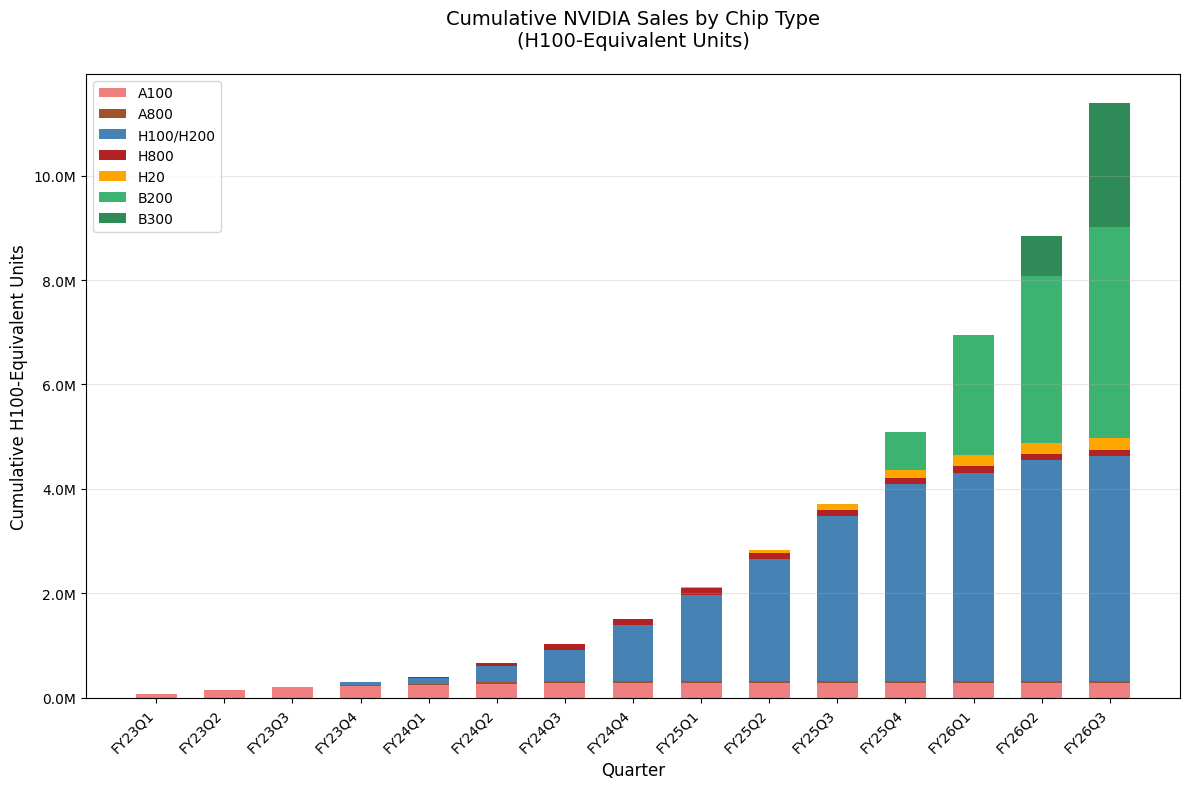

In [28]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
quarters = list(sim_results.keys())

# Get median values for each chip type, converted to H100-equivalents
chip_medians = {}
for chip in CHIP_TYPES:
    quarterly_medians = [np.median(sim_results[q][chip]) for q in quarters]
    h100e_ratio = CHIP_SPECS[chip]['tops'] / H100_TOPS
    chip_medians[chip] = np.array(quarterly_medians) * h100e_ratio

# Calculate cumulative sums
chip_cumulative = {chip: np.cumsum(chip_medians[chip]) for chip in CHIP_TYPES}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

bottom = np.zeros(len(quarters))
for chip in CHIP_TYPES:
    ax.bar(x, chip_cumulative[chip], width, label=chip, bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_cumulative[chip]

ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# ==============================================
# EXPORT NON-INTERPOLATED FISCAL QUARTER RESULTS
# ==============================================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Estimates generated on: {timestamp}"

# Create rows for output (fiscal quarters, non-interpolated)
rows = []

for quarter in QUARTERS:
    start_date = revenue_df.loc[quarter, 'Start Date']
    end_date = revenue_df.loc[quarter, 'End Date']
    
    for chip_type in CHIP_SPECS:
        arr = np.array(sim_results[quarter][chip_type])
        if arr.sum() > 0:
            # Calculate percentiles for units
            u_p5, u_p50, u_p95 = [int(np.percentile(arr, p)) for p in [5, 50, 95]]
            
            # Calculate H100 equivalents
            h100e_factor = CHIP_SPECS[chip_type]['tops'] / H100_TOPS
            h_p5, h_p50, h_p95 = [int(p * h100e_factor) for p in [u_p5, u_p50, u_p95]]
            
            # Use display name (H100/H200 -> H100 for display)
            display_name = 'H100' if chip_type == 'H100/H200' else chip_type
            
            rows.append({
                'Name': f"{quarter} - {display_name}",
                'Chip manufacturer': 'Nvidia',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': h_p50,
                'H100e (5th percentile)': h_p5,
                'H100e (95th percentile)': h_p95,
                'Number of Units': u_p50,
                'Number of Units (5th percentile)': u_p5,
                'Number of Units (95th percentile)': u_p95,
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': display_name,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
nvidia_chip_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_chip_timelines.csv'
nvidia_chip_timelines.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(nvidia_chip_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                              'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                              'H100e (95th percentile)', 'Number of Units', 'Chip type']].to_string())

Exported to nvidia_chip_timelines.csv
             Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units Chip type
0   FY23Q1 - A100            Nvidia  2022-01-31  2022-05-01                               70607                   54241                    91570           223929      A100
1   FY23Q2 - A100            Nvidia  2022-05-02  2022-07-31                               71752                   54888                    93105           227562      A100
2   FY23Q3 - A100            Nvidia  2022-08-01  2022-10-30                               64761                   49957                    84132           205390      A100
3   FY23Q3 - H100            Nvidia  2022-08-01  2022-10-30                                9109                    7680                    10746             9109      H100
4   FY23Q4 - A100            Nvidia  2022-10-31  2023-01-29                               21087       

In [30]:
# ==============================================
# INTERPOLATE TO CALENDAR QUARTERS
# ==============================================

# Use Start Date and End Date directly from revenue_df
quarter_dates = {q: (revenue_df.loc[q, 'Start Date'], revenue_df.loc[q, 'End Date']) for q in QUARTERS}

print("NVIDIA fiscal quarter to calendar date mapping:")
for q, (start, end) in quarter_dates.items():
    print(f"  {q}: {start} to {end}")

# Interpolate to calendar quarters
calendar_results = interpolate_to_calendar_quarters(sim_results, quarter_dates, verbose=False)

# Display summary
calendar_summary = summarize_calendar_quarters(calendar_results)
print("\nNVIDIA Chip Volumes by Calendar Quarter (median with 90% CI)")
print(calendar_summary.to_string(index=False))

NVIDIA fiscal quarter to calendar date mapping:
  FY23Q1: 2022-01-31 to 2022-05-01
  FY23Q2: 2022-05-02 to 2022-07-31
  FY23Q3: 2022-08-01 to 2022-10-30
  FY23Q4: 2022-10-31 to 2023-01-29
  FY24Q1: 2023-01-30 to 2023-04-30
  FY24Q2: 2023-05-01 to 2023-07-30
  FY24Q3: 2023-07-31 to 2023-10-29
  FY24Q4: 2023-10-30 to 2024-01-28
  FY25Q1: 2024-01-29 to 2024-04-28
  FY25Q2: 2024-04-29 to 2024-07-28
  FY25Q3: 2024-07-29 to 2024-10-27
  FY25Q4: 2024-10-28 to 2025-01-26
  FY26Q1: 2025-01-27 to 2025-04-27
  FY26Q2: 2025-04-28 to 2025-07-27
  FY26Q3: 2025-07-28 to 2025-10-26

NVIDIA Chip Volumes by Calendar Quarter (median with 90% CI)
Quarter             A100          A800        H100/H200          H800              H20             B200             B300               Total
Q1 2022 148k (113k-191k)             -                -             -                -                -                -    148k (113k-191k)
Q2 2022 226k (173k-294k)             -                -             -              

In [31]:
# verify_calendar_quarter_interpolation(sim_results, calendar_results, quarter_dates)

In [32]:
# ==============================================
# EXPORT INTERPOLATED CALENDAR QUARTER RESULTS
# ==============================================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Estimates generated on: {timestamp}"

# Get first and last dates from Nvidia fiscal quarter data
nvidia_first_start = revenue_df['Start Date'].iloc[0]
nvidia_last_end = revenue_df['End Date'].iloc[-1]

# Parse date strings to datetime for comparison
def parse_date(date_str):
    """Parse date string to datetime."""
    return pd.to_datetime(date_str)

nvidia_first_start_dt = parse_date(nvidia_first_start)
nvidia_last_end_dt = parse_date(nvidia_last_end)

# Calendar quarter to date range mapping
def get_calendar_quarter_dates(cal_q):
    """Return (start_date, end_date) strings for a calendar quarter like 'Q1 2024'."""
    parts = cal_q.split()
    q_num = int(parts[0][1])
    year = int(parts[1])
    if q_num == 1:
        return f"1/1/{year}", f"3/31/{year}"
    elif q_num == 2:
        return f"4/1/{year}", f"6/30/{year}"
    elif q_num == 3:
        return f"7/1/{year}", f"9/30/{year}"
    else:
        return f"10/1/{year}", f"12/31/{year}"

def format_date_for_note(dt):
    """Format datetime as M/D/YYYY for notes."""
    return dt.strftime('%-m/%-d/%Y') if hasattr(dt, 'strftime') else str(dt)

def get_incomplete_note(cal_q_start, cal_q_end):
    """Return note if calendar quarter extends beyond Nvidia fiscal data coverage."""
    cal_start_dt = pd.to_datetime(cal_q_start, format='%m/%d/%Y')
    cal_end_dt = pd.to_datetime(cal_q_end, format='%m/%d/%Y')

    starts_before = cal_start_dt < nvidia_first_start_dt
    ends_after = cal_end_dt > nvidia_last_end_dt

    first_start_str = format_date_for_note(nvidia_first_start_dt)
    last_end_str = format_date_for_note(nvidia_last_end_dt)

    if starts_before and ends_after:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters beginning {first_start_str} and ending {last_end_str}"
    elif starts_before:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters beginning {first_start_str}"
    elif ends_after:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters ending {last_end_str}"
    return None

# Create rows for output
rows = []

for quarter in calendar_results:
    start_date, end_date = get_calendar_quarter_dates(quarter)
    incomplete_note = get_incomplete_note(start_date, end_date)

    for chip_type in CHIP_SPECS:
        stats = calendar_results[quarter][chip_type]
        if stats['p50'] > 0:
            # Calculate H100 equivalents
            h100e_factor = CHIP_SPECS[chip_type]['tops'] / H100_TOPS

            # Build notes field
            notes = generated_note
            if incomplete_note:
                notes = f"{incomplete_note}. {notes}"

            rows.append({
                'Name': f"{quarter} - {chip_type}",
                'Chip manufacturer': 'Nvidia',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(stats['p50'] * h100e_factor),
                'H100e (5th percentile)': int(stats['p5'] * h100e_factor),
                'H100e (95th percentile)': int(stats['p95'] * h100e_factor),
                'Number of Units': int(stats['p50']),
                'Number of Units (5th percentile)': int(stats['p5']),
                'Number of Units (95th percentile)': int(stats['p95']),
                'Source / Link': '',
                'Notes': notes,
                'Chip type': chip_type,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
nvidia_timelines_interpolated = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_timelines_interpolated.csv'
nvidia_timelines_interpolated.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(f"Nvidia fiscal data coverage: {format_date_for_note(nvidia_first_start_dt)} to {format_date_for_note(nvidia_last_end_dt)}")
print(nvidia_timelines_interpolated[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                                      'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                                      'H100e (95th percentile)', 'Number of Units', 'Number of Units (5th percentile)',
                                      'Number of Units (95th percentile)', 'Chip type', 'Notes']].to_string())

Exported to nvidia_timelines_interpolated.csv
Nvidia fiscal data coverage: 1/31/2022 to 10/26/2025
                   Name Chip manufacturer Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units  Number of Units (5th percentile)  Number of Units (95th percentile)  Chip type                                                                                                                               Notes
0        Q1 2022 - A100            Nvidia   1/1/2022   3/31/2022                               46554                   35763                    60376           147645                            113423                             191482       A100  Estimate is incomplete because it is based on Nvidia fiscal quarters beginning 1/31/2022. Estimates generated on: 01-28-2026 12:48
1        Q2 2022 - A100            Nvidia   4/1/2022   6/30/2022                               71362                   54668                   